# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Get data

In [3]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [4]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [5]:
current_event = 30
element_types = [2, 3, 4]
threshold_minutes = 1

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [7]:
player.add_home_categorical_variable(element_gameweek_df)

# Poisson player minutes model

## Preparing data

In [8]:
sppmm_df = element_gameweek_df.copy()

In [9]:
sppmm_df = player.add_categorical_variables(sppmm_df, 'opposition_team')
sppmm_df = player.add_categorical_variables(sppmm_df, 'element')

In [10]:
sppmm_redundant_columns = [
    'row_id', 'goals_scored', 'attempted_passes', 'big_chances_created',
    'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
    'clearances_blocks_interceptions', 'completed_passes', 'creativity',
    'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
    'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
    'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time',
    'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'offside',
    'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded',
    'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round',
    'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
    'team_h_score', 'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'winning_goals',
    'yellow_cards', 'event', 'team_a', 'team_a_difficulty', 'team_h',
    'team_h_difficulty', 'element_type', 'team', 'web_name', 'safe_web_name',
    'own_team', 'opposition_team', 'was_home', 'minutes'
]

In [11]:
sppmm_df['log_minutes'] = np.log(sppmm_df['minutes'])

In [12]:
sppmm_df = player.remove_redundant_columns(sppmm_df, sppmm_redundant_columns)

In [13]:
sppmm_response_df, sppmm_explanatory_df = player.get_response_explanatory_dfs(sppmm_df, 'assists')

## Fitting model

In [14]:
sppmm_results = sm.GLM(
    sppmm_response_df,
    sppmm_explanatory_df,
    family=sm.families.Poisson(),
    missing='drop'
).fit()

In [15]:
print(sppmm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                assists   No. Observations:                 7649
Model:                            GLM   Df Residuals:                     7170
Model Family:                 Poisson   Df Model:                          478
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2003.3
Date:                Sat, 16 Mar 2019   Deviance:                       2617.2
Time:                        16:50:49   Pearson chi2:                 5.04e+03
No. Iterations:                    25                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -30.6337   2.06e+05     -0.000      1.000   -4.03e+05    4.03e+05
opposition_team_2      0.328

## Model fit

### Significant explanatory variable

In [16]:
sppmm_results.params[sppmm_results.pvalues < 0.10]

opposition_team_4     0.427016
opposition_team_5     0.438475
opposition_team_9     0.570850
opposition_team_12   -0.819643
opposition_team_13   -0.603863
log_minutes           0.593046
dtype: float64

### Residuals

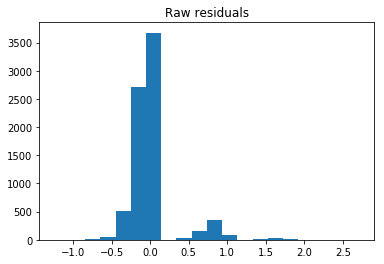

In [17]:
plt.figure()
plt.hist(sppmm_results.resid_response, bins=20)
plt.title('Raw residuals')
plt.show()

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/genmod/families/family.py:340: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2 * (endog * np.log(endog_mu) - (endog - mu))) / scale)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/tom/footbot/venv/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


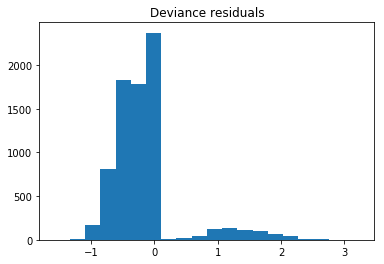

In [18]:
plt.figure()
plt.hist(sppmm_results.resid_deviance, bins=20)
plt.title('Deviance residuals')
plt.show()

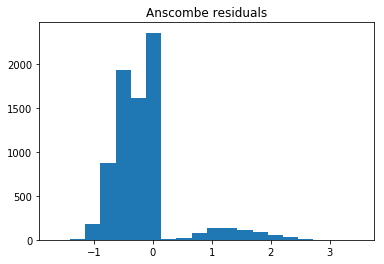

In [19]:
plt.figure()
plt.hist(sppmm_results.resid_anscombe, bins=20)
plt.title('Anscombe residuals')
plt.show()

In [20]:
element_gameweek_df['deviance_residual'] = sppmm_results.resid_deviance
element_gameweek_df['abs_deviance_residual'] = abs(sppmm_results.resid_deviance)
element_gameweek_df['raw_residual'] = sppmm_results.resid_response
element_gameweek_df['abs_raw_residual'] = abs(sppmm_results.resid_response)

#### Deviance contribution by opposition team

In [21]:
element_gameweek_df.groupby('opposition_team')['abs_raw_residual'].mean().sort_values()

opposition_team
12    0.071717
13    0.075906
6     0.119877
17    0.125678
20    0.136557
1     0.137294
15    0.142075
3     0.143123
11    0.148538
14    0.153172
8     0.153202
7     0.154770
18    0.157534
19    0.163248
10    0.177492
2     0.181498
16    0.184119
4     0.194539
5     0.197393
9     0.219016
Name: abs_raw_residual, dtype: float64

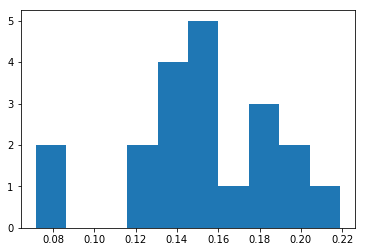

In [22]:
plt.figure()
plt.hist(element_gameweek_df.groupby('opposition_team')['abs_raw_residual'].mean())
plt.show()

#### Deviance contribution by player

In [23]:
element_gameweek_df.groupby(['element', 'safe_web_name'])['minutes'].sum().sort_values()[:20]

element  safe_web_name
443      souare            1
148      sako              1
603      chong             1
602      garner            1
557      camacho           1
562      johnson           1
523      amos              2
566      willock           2
497      nkoudou           4
588      barreca           4
552      nketiah           5
563      saka              7
568      gomes             9
574      gallagher         9
608      greenwood        10
599      surridge         10
10       mavropanos       11
377      prodl            13
607      rowe             14
560      xande silva      17
Name: minutes, dtype: int64

In [24]:
element_gameweek_df.groupby(['element', 'safe_web_name'])['abs_raw_residual'].mean().sort_values()[:20]

element  safe_web_name
497      nkoudou          5.484502e-14
443      souare           6.681609e-13
148      sako             6.681609e-13
216      fuchs            6.681610e-13
385      navarro          6.681610e-13
557      camacho          6.681610e-13
562      johnson          6.681610e-13
568      gomes            6.681610e-13
601      duhaney          6.681610e-13
232      diabate          6.681610e-13
491      gibson           6.681610e-13
560      xande silva      6.681610e-13
377      prodl            6.681610e-13
523      amos             6.681610e-13
114      cahill           6.681610e-13
588      barreca          6.681610e-13
342      sims             6.681610e-13
566      willock          6.681610e-13
594      markovic         6.681610e-13
602      garner           6.681610e-13
Name: abs_raw_residual, dtype: float64

In [25]:
element_gameweek_df.groupby(['element', 'safe_web_name'])['abs_raw_residual'].mean().sort_values()[-20:]

element  safe_web_name   
367      son                 0.425571
8        kolasinac           0.429842
245      alexander-arnold    0.440967
40       fraser              0.441386
247      robertson           0.443999
253      salah               0.452906
364      eriksen             0.453392
280      aguero              0.462546
378      holebas             0.481591
275      sane                0.488355
22       lacazette           0.490264
302      pogba               0.511525
43       wilson              0.514581
591      tielemans           0.514986
122      hazard              0.521550
575      babel               0.584740
270      sterling            0.597934
279      zinchenko           0.623517
267      mendy               0.642388
358      walker-peters       0.830221
Name: abs_raw_residual, dtype: float64

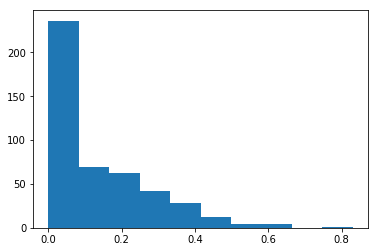

In [26]:
plt.figure()
plt.hist(element_gameweek_df.groupby(['element', 'safe_web_name'])['abs_raw_residual'].mean())
plt.show()

#### Deviance contribution by minutes played

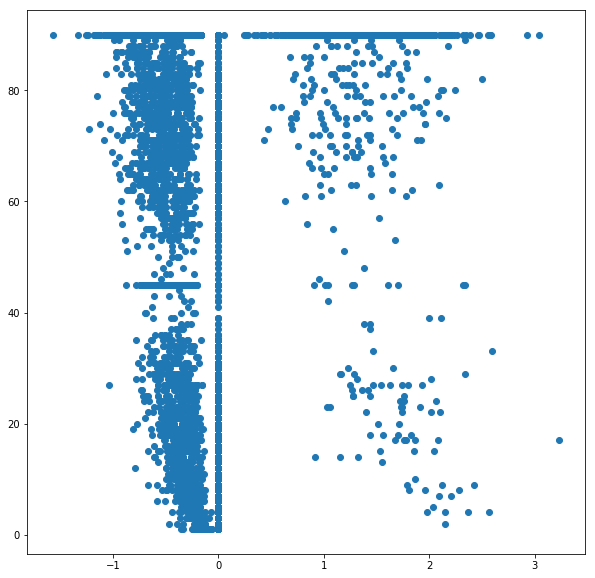

In [27]:
plt.figure(figsize=(10, 10))
plt.scatter(element_gameweek_df['deviance_residual'], element_gameweek_df['minutes'])
plt.show()

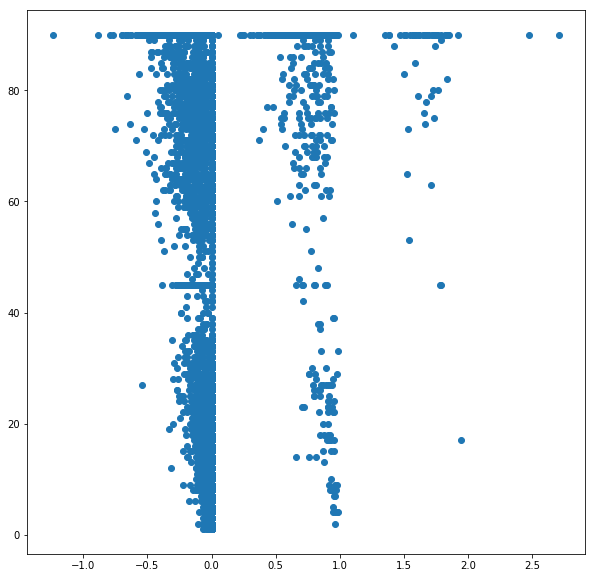

In [28]:
plt.figure(figsize=(10, 10))
plt.scatter(element_gameweek_df['raw_residual'], element_gameweek_df['minutes'])
plt.show()

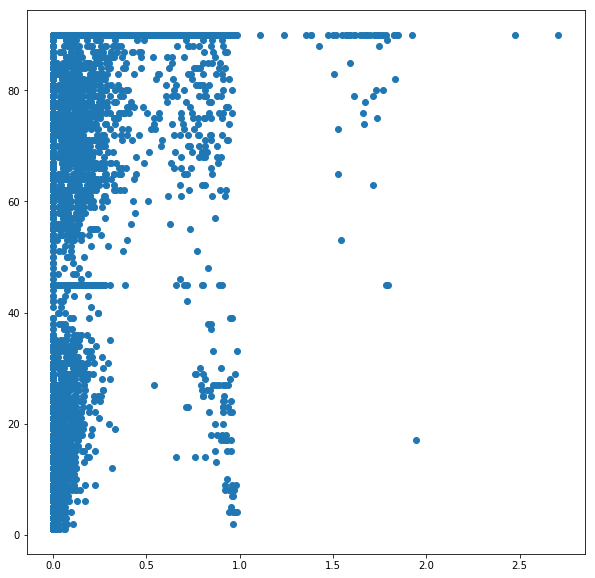

In [29]:
plt.figure(figsize=(10, 10))
plt.scatter(element_gameweek_df['abs_raw_residual'], element_gameweek_df['minutes'])
plt.show()

In [30]:
element_gameweek_df['minutes_binned'] = pd.cut(element_gameweek_df['minutes'], 10)

In [31]:
element_gameweek_df.groupby('minutes_binned')['abs_raw_residual'].mean().sort_index()

minutes_binned
(0.911, 9.9]    0.045893
(9.9, 18.8]     0.072172
(18.8, 27.7]    0.118713
(27.7, 36.6]    0.104583
(36.6, 45.5]    0.122440
(45.5, 54.4]    0.130586
(54.4, 63.3]    0.135961
(63.3, 72.2]    0.181994
(72.2, 81.1]    0.221542
(81.1, 90.0]    0.168826
Name: abs_raw_residual, dtype: float64

In [32]:
element_gameweek_df.groupby('minutes_binned')['abs_raw_residual'].std().sort_index()

minutes_binned
(0.911, 9.9]    0.162840
(9.9, 18.8]     0.185113
(18.8, 27.7]    0.223702
(27.7, 36.6]    0.179735
(36.6, 45.5]    0.237402
(45.5, 54.4]    0.240595
(54.4, 63.3]    0.200194
(63.3, 72.2]    0.231689
(72.2, 81.1]    0.309299
(81.1, 90.0]    0.271523
Name: abs_raw_residual, dtype: float64

#### Deviance contribution by element type

In [33]:
element_gameweek_df.groupby('element_type')['abs_raw_residual'].mean().sort_values()

element_type
2    0.102375
3    0.178925
4    0.183205
Name: abs_raw_residual, dtype: float64

#### Deviance contribution by goals scored

In [34]:
element_gameweek_df.groupby('assists')['abs_raw_residual'].mean().sort_values()

assists
0    0.083309
1    0.783185
2    1.653332
3    2.282305
Name: abs_raw_residual, dtype: float64

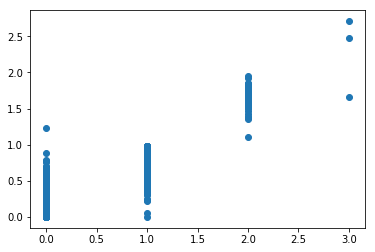

In [35]:
plt.figure()
plt.scatter(element_gameweek_df['assists'], element_gameweek_df['abs_raw_residual'])
plt.show()